# Sign Lenguage MNIST

**Universitario:** Pinto Barrón Osvaldo Dennis.

**Carrera:** Ingeniería en Diseño y Animación Digital.

**Temática del dataset:** Representación gráfica del lenguaje de señas americano, excluyendo las letras J y Z debido a los movimientos gestuales.

**Enlace del dataset:**  [Sign Language MNIST](https://www.kaggle.com/datasets/datamunge/sign-language-mnist)

**Formato:** Está diseñado para coincidir estrechamente con el MNIST clásico. Cada caso de entrenamiento y prueba representa una etiqueta (0-24) como un mapa uno a uno para cada letra del alfabeto de la A a la Z (y no hay casos para 9=J o 25=Z debido a los movimientos gestuales).

El dataset se divide de la siguiente forma:


*   Datos de entrenamiento (27.455 casos).
*   Datos de prueba (7172 casos).



Columnas usadas para la realización de la clasificación:



*   **Variables de entrada:** Se usan 784 columnas, que tienen los pixeles de las imágenes a escala de grises con valores que van desde el 0 al 255.
*   **Variable de salida:**
Contiene la etiqueta que va del 0 al 24, representando una letra del abecedario (A-Z) a través del lenguaje de señas.






# Clasificación Multivariable (One vs All)
## Importación de librerías
Importación de archivos desde la nube de Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Librerías necesarias para el manejo de cálculo, manejo de datos, gráficas y optimización.

In [2]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np

# Manejo de datos
import pandas as pd

# Libreria para graficos
from matplotlib import pyplot
import matplotlib.pyplot as plt

# Modulo de optimizacion en scipy
from scipy import optimize

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

## 1. Cargamos los datos
Los datos de entrenamiento del dataset **sign_mnist_train.csv** poseen 27.455 datos.


In [3]:
# Cargar el archivo CSV, especificando que hay un encabezado en la primera fila
data_original = pd.read_csv('/content/drive/MyDrive/Datasets/sign_mnist_train.csv')

# Imprimir las primeras filas del DataFrame para verificar
data_original.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### 1.1 Insertar atributos que contengan, caracteres, texto y valores booleanos.
+ **i % len(origins, difficulties):** Esto permite que el índice i se "reinicie" al llegar al final de la lista origins, asegurando que todos los valores se distribuyan uniformemente.

In [4]:
# Generar una lista de valores distribuidos uniformemente para cada atributo inventado
origins = ['ASL', 'BSL', 'ISL']
difficulties = ['easy', 'medium', 'hard']

# Crear los atributos inventados usando ciclos para alcanzar la longitud adecuada
data_original['Señal_origen'] = [origins[i % len(origins)] for i in range(len(data_original))]
data_original['Señal_comun'] = data_original['label'].apply(lambda x: x in [0, 1, 2, 3, 4])
data_original['Dificultad'] = [difficulties[i % len(difficulties)] for i in range(len(data_original))]

# Verificar la inserción correcta de los nuevos atributos
data_original.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Señal_origen,Señal_comun,Dificultad
0,3,107,118,127,134,139,143,146,150,153,...,207,206,206,206,204,203,202,ASL,True,easy
1,6,155,157,156,156,156,157,156,158,158,...,87,94,163,175,103,135,149,BSL,False,medium
2,2,187,188,188,187,187,186,187,188,187,...,199,198,199,198,195,194,195,ISL,True,hard
3,2,211,211,212,212,211,210,211,210,210,...,231,230,226,225,222,229,163,ASL,True,easy
4,13,164,167,170,172,176,179,180,184,185,...,108,133,163,157,163,164,179,BSL,False,medium


### 1.2 Duplicación de ejemplos con pequeñas variaciones

Creamos una función para duplicar el dataset sintético. Es decir, tendremos 54.910 datos con pequeñas variaciones (0 a 5) en los valores de 0 a 255.

+ **X_dup:** Los datos modificados a partir del dataset original con pequeñas variaciones.
+ **y_dup:** Toma una copia de los valores originales de la etiqueta.
+ **np.vstack:** Combinas el dataset original (X_original) con el dataset variado (X_sintetico) para crear el dataset duplicado.

In [5]:
def duplicar_dataset(X, y, min_val = 0, max_val = 1):

    # Normalizar los datos originales
    X_norm = (X - X.min()) / (X.max() - X.min()) * (max_val - min_val) + min_val

    # Duplicar los datos originales
    X_dup = X_norm.copy()
    y_dup = y.copy()

    # Añadir pequeñas variaciones aleatorias a las imágenes
    noise = np.random.normal(0, 0.05, X.shape)  # Variaciones pequeñas
    X_dup = np.clip(X_dup + noise, 0, 255)  # Asegura valores válidos de píxeles

    # Convertir las variaciones a enteros
    #X_dup = np.round(X_dup).astype(int)

    # Concatenar dataset original con el duplicado
    X_synthetic = np.vstack((X, X_dup))
    y_synthetic = np.concatenate((y, y_dup))

    return X_synthetic, y_synthetic

Convertimos el dataset a un vector numpy.

**Importante:** Destacamos los atributos inventados por las siguientes razones:
+ **Compatibilidad con el Modelo:**Los atributos inventados, como los de texto o booleanos, no aportan directamente al proceso de clasificación basado en píxeles.

+ **Formato de Entrada para Numpy:** No son compatibles con las operaciones matemáticas realizadas en el entrenamiento de modelos de regresión logística, ya que estas operaciones esperan matrices numéricas.

+ **Enfoque en Características Relevantes:** Los atributos inventados se añadieron para enriquecer el contexto y complejidad del dataset, pero no son esenciales para el entrenamiento del modelo.

In [6]:
X_original = data_original.drop(['label', 'Señal_origen', 'Señal_comun', 'Dificultad'], axis=1).values / 255.0 # Normalización
y_original = data_original['label'].values

Llamamos a la función para duplicar los datos.

In [7]:
X_sintetico, y_sintetico = duplicar_dataset(X_original, y_original)

# Verificamos el tamaño
print(X_sintetico.shape)
print(y_sintetico.shape)

(54910, 784)
(54910,)


Comprobamos que haya una varación a partir del dato 27456.


In [8]:
print(X_original[:5])          # Muestra las primeras filas del dataset original
print(X_sintetico[27455:27460]) # Muestra filas después del punto de duplicación para verificar la variación

[[0.41960784 0.4627451  0.49803922 ... 0.8        0.79607843 0.79215686]
 [0.60784314 0.61568627 0.61176471 ... 0.40392157 0.52941176 0.58431373]
 [0.73333333 0.7372549  0.7372549  ... 0.76470588 0.76078431 0.76470588]
 [0.82745098 0.82745098 0.83137255 ... 0.87058824 0.89803922 0.63921569]
 [0.64313725 0.65490196 0.66666667 ... 0.63921569 0.64313725 0.70196078]]
[[0.37007943 0.5218958  0.60260247 ... 0.8222126  0.83332611 0.7110993 ]
 [0.62287858 0.67506447 0.59441739 ... 0.47400969 0.5647994  0.57719585]
 [0.7431452  0.73737448 0.7259249  ... 0.80535574 0.75227107 0.74796156]
 [0.84680131 0.80713428 0.82934554 ... 0.8265825  0.93357432 0.64469035]
 [0.63197107 0.71884021 0.67356077 ... 0.57327348 0.67087408 0.67788272]]


### 1.3 Visualización de imágenes del dataset original y duplicado
Creamos una función para graficar 10 imágenes de forma randómica.

In [9]:
def plot_images(X, title, start_index=0):
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    fig.suptitle(title)
    indices = np.arange(start_index, start_index + 10) # Selecciona 10 imágenes a partir del start_index
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(X[indices[i]].reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

Llamamos a la función

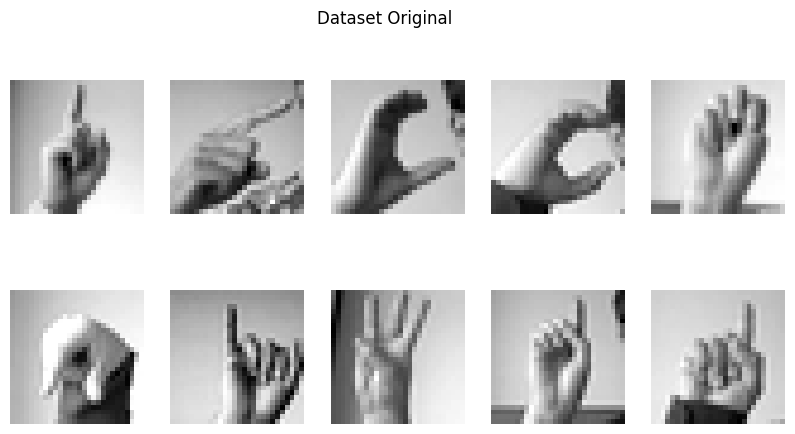

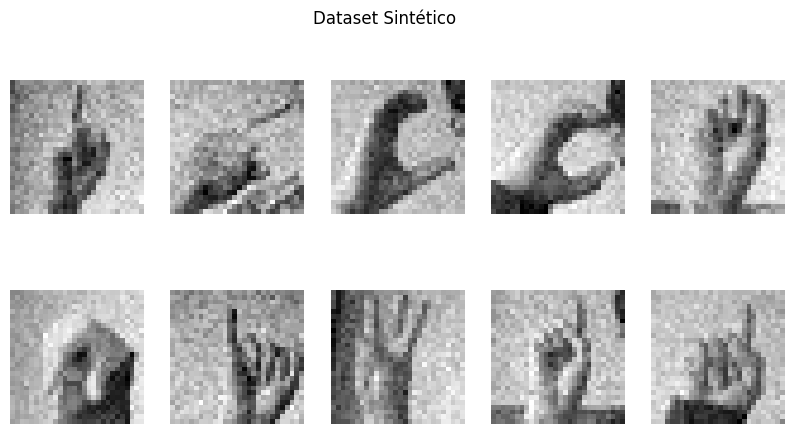

In [10]:
plot_images(X_original, 'Dataset Original')
plot_images(X_sintetico, 'Dataset Sintético', start_index=27455)

### 1.4 División en datos de entrenamiento y prueba

In [11]:
# Dividir los datos en entrenamiento (80%) y prueba (20%)
m = X_sintetico.shape[0]
train_size = int(m * 0.8)

X_train = X_sintetico[:train_size]
y_train = y_sintetico[:train_size]
X_test = X_sintetico[train_size:]
y_test = y_sintetico[train_size:]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(43928, 784)
(43928,)
(10982, 784)
(10982,)


### 1.5 Entrenar los modelos de regresión logística para cada clase

#### 1.5.1 Función sigmoide (z)

In [12]:
def sigmoid(z):

    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))

#### 1.5.2 Función del costo y el gradiente

In [13]:
def lrCostFunction(theta, X, y, lambda_=0.1):
    m = y.size

    if y.dtype == bool:
        y = y.astype(int)

    J = 0
    h = sigmoid(X.dot(theta.T))

    # Evitar valores de h que sean 0 o 1
    epsilon = 1e-10
    h = np.clip(h, epsilon, 1 - epsilon)

    temp = theta.copy()
    temp[0] = 0

    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))

    grad = (1 / m) * (h - y).dot(X)
    grad = grad + (lambda_ / m) * temp

    return J, grad

#### 1.5.3 Función descenso por el Gradiente

In [14]:
def descensoGradiente(theta, X, y, alpha, num_iters, lambda_=0.1):
    # Inicializa algunos valores
    m = y.shape[0]  # Número de ejemplos de entrenamiento

    # Realiza una copia de theta, el cual será actualizada por el descenso por el gradiente
    theta = theta.copy()
    J_history = []

    for i in range(num_iters):
        # Calcula la hipótesis usando la función sigmoide
        h = sigmoid(X.dot(theta.T))

        # Actualiza theta usando el gradiente descendente
        theta = theta - (alpha / m) * (h - y).dot(X)

        # Calcula el costo con la función lrCostFunction (asegurando que solo se obtenga el costo)
        cost, _ = lrCostFunction(theta, X, y, lambda_)
        J_history.append(cost)

    return theta, J_history

#### 1.5.4 Entrenamiento

In [15]:
# Tenemos 25 etiquetas (0-24)
num_labels = 25
n = X_train.shape[1] # Número de características
all_theta = np.zeros((num_labels, n))

alpha = 0.001
num_iters = 100 # número de iteraciones
lambda_ = 0.01 # parámetro de regularización

Almacenamos los costos de cada clase e imprimimos los costos finales.

In [16]:
# Almacenar los costos finales de cada modelo binario
final_costs = []
cost_histories = []

# Entrenamiento de modelos binarios para cada clase
for c in range(num_labels):
    initial_theta = np.zeros(n)
    theta, J_history = descensoGradiente(initial_theta, X_train, (y_train == c).astype(int), alpha, num_iters)
    all_theta[c] = theta
    final_costs.append(J_history[-1])  # Captura del costo final después de todas las iteraciones
    cost_histories.append(J_history)   # Almacena el historial de costos

    # Imprimir el costo final para cada modelo binario
    print(f'Costo final del modelo binario para la clase {c}: {J_history[-1]:.4f}')


Costo final del modelo binario para la clase 0: 0.1807
Costo final del modelo binario para la clase 1: 0.1698
Costo final del modelo binario para la clase 2: 0.1783
Costo final del modelo binario para la clase 3: 0.1888
Costo final del modelo binario para la clase 4: 0.1662
Costo final del modelo binario para la clase 5: 0.1860
Costo final del modelo binario para la clase 6: 0.1778
Costo final del modelo binario para la clase 7: 0.1657
Costo final del modelo binario para la clase 8: 0.1915
Costo final del modelo binario para la clase 9: 0.0389
Costo final del modelo binario para la clase 10: 0.1699
Costo final del modelo binario para la clase 11: 0.1929
Costo final del modelo binario para la clase 12: 0.1725
Costo final del modelo binario para la clase 13: 0.1858
Costo final del modelo binario para la clase 14: 0.1856
Costo final del modelo binario para la clase 15: 0.1527
Costo final del modelo binario para la clase 16: 0.1741
Costo final del modelo binario para la clase 17: 0.2026
Co

#### 1.5.5 Gráfica de costos por clase

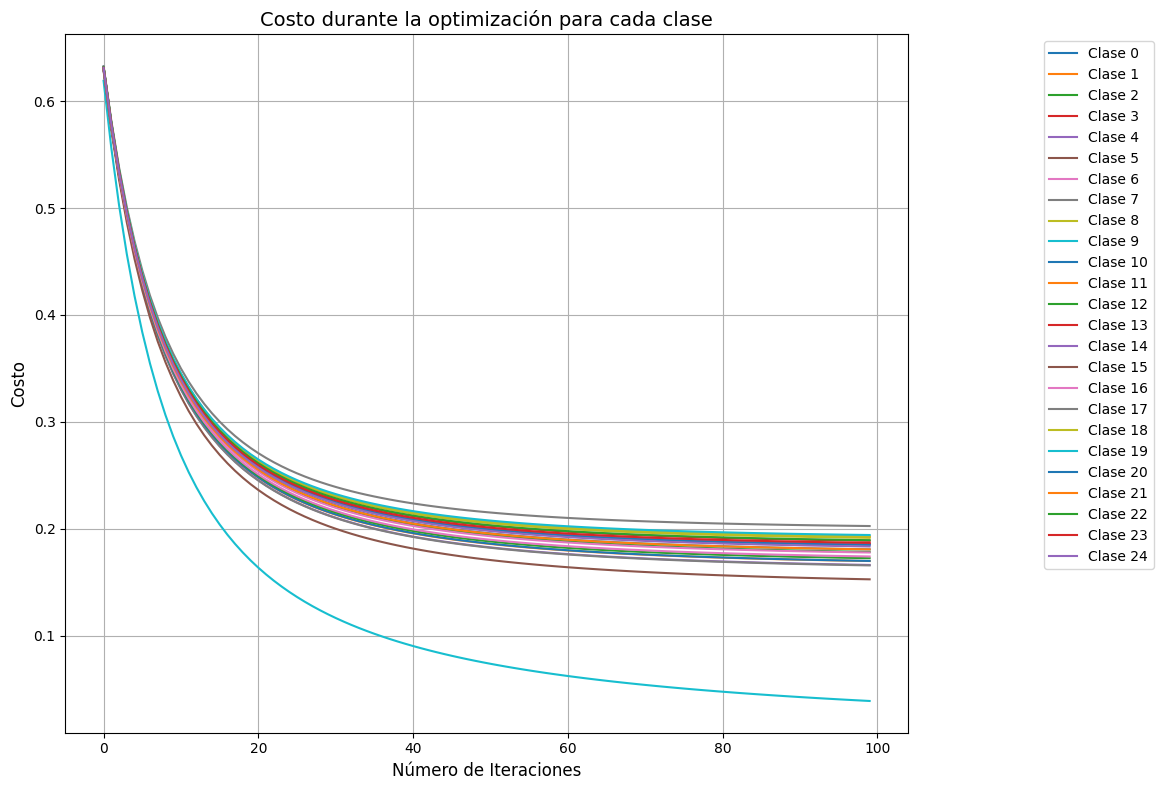

In [17]:
# Graficar los costos finales para cada clase
plt.figure(figsize=(12, 8))
for c in range(num_labels):
    plt.plot(np.arange(num_iters), cost_histories[c], label=f'Clase {c}')
plt.xlabel('Número de Iteraciones', fontsize=12)
plt.ylabel('Costo', fontsize=12)
plt.title('Costo durante la optimización para cada clase', fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=10)
plt.grid(True)
plt.tight_layout()  # Ajusta el gráfico para que no se superponga
plt.show()

#### 1.5.5 Predicciones

+ **Función predict_binary:** Realiza predicciones binarias utilizando los parámetros entrenados (theta) para cada clase. La predicción es 1 si la probabilidad es mayor o igual a 0.5, de lo contrario es 0.

+ **Función calculate_binary_accuracy:** Calcula la precisión para las predicciones binarias comparando las predicciones con las etiquetas verdaderas.

In [18]:
def predict_binary(theta, X):
    prob = sigmoid(X.dot(theta.T))
    # Predecir la clase: 1 si la probabilidad es mayor o igual a 0.5, de lo contrario 0
    return (prob >= 0.5).astype(int)

def calculate_binary_accuracy(predictions, actual):
    # Calcular la precisión comparando las predicciones con las etiquetas reales
    return np.mean(predictions == actual) * 100

# Inicializar variables para las predicciones y la precisión
binary_train_accuracies = []
binary_test_accuracies = []

for c in range(num_labels):
    # Realizar predicciones para los datos de entrenamiento y prueba
    y_pred_train = predict_binary(all_theta[c], X_train)
    y_pred_test = predict_binary(all_theta[c], X_test)

    # Calcular la precisión para los datos de entrenamiento
    accuracy_train = calculate_binary_accuracy(y_pred_train, (y_train == c).astype(int))
    binary_train_accuracies.append(accuracy_train)

    # Calcular la precisión para los datos de prueba
    accuracy_test = calculate_binary_accuracy(y_pred_test, (y_test == c).astype(int))
    binary_test_accuracies.append(accuracy_test)

    # Imprimir la precisión para cada clase en los datos de entrenamiento y prueba
    print(f'Precisión binaria para la clase {c} en los datos de entrenamiento: {accuracy_train:.2f}%')
    print(f'Precisión binaria para la clase {c} en los datos de prueba: {accuracy_test:.2f}%\n')

Precisión binaria para la clase 0 en los datos de entrenamiento: 95.89%
Precisión binaria para la clase 0 en los datos de prueba: 95.93%

Precisión binaria para la clase 1 en los datos de entrenamiento: 96.29%
Precisión binaria para la clase 1 en los datos de prueba: 96.45%

Precisión binaria para la clase 2 en los datos de entrenamiento: 95.81%
Precisión binaria para la clase 2 en los datos de prueba: 95.91%

Precisión binaria para la clase 3 en los datos de entrenamiento: 95.65%
Precisión binaria para la clase 3 en los datos de prueba: 95.61%

Precisión binaria para la clase 4 en los datos de entrenamiento: 96.46%
Precisión binaria para la clase 4 en los datos de prueba: 96.71%

Precisión binaria para la clase 5 en los datos de entrenamiento: 95.65%
Precisión binaria para la clase 5 en los datos de prueba: 95.47%

Precisión binaria para la clase 6 en los datos de entrenamiento: 95.99%
Precisión binaria para la clase 6 en los datos de prueba: 96.19%

Precisión binaria para la clase 7 

### 1.6 Modelo One_vs_all
También haremos uso de la función para graficar el costo.

+ **cost_histories:** Inicializa una lista de listas para almacenar el costo de la función de costo en cada iteración para cada clase.

+ **callback** es una función interna que se llama después de cada iteración. Calcula el costo actual y lo agrega a la lista cost_histories correspondiente.

In [19]:
def oneVsAll(X, y, num_labels, lambda_):
    m, n = X.shape
    all_theta = np.zeros((num_labels, n + 1))
    X = np.concatenate([np.ones((m, 1)), X], axis=1)  # Añadir columna de unos para el término de sesgo

    cost_histories = [[] for _ in range(num_labels)]  # Lista de listas para almacenar el costo por iteración para cada clase

    for c in range(num_labels):
        initial_theta = np.zeros(n + 1)
        options = {'maxiter': 300, 'disp': False}

        # Función callback para almacenar el costo en cada iteración
        def callback(theta):
            cost, _ = lrCostFunction(theta, X, (y == c), lambda_)
            cost_histories[c].append(cost)

        res = optimize.minimize(lrCostFunction,
                                initial_theta,
                                args=(X, (y == c), lambda_),
                                jac=True,
                                method='CG',
                                callback=callback,  # Usar el callback aquí
                                options=options)

        all_theta[c] = res.x

        # Imprimir el costo final para la clase actual
        final_cost = cost_histories[c][-1]
        print(f'Costo final para la clase {c}: {final_cost:.4f}')

    return all_theta, cost_histories

In [20]:
all_theta, cost_histories  = oneVsAll(X_train, y_train, num_labels, lambda_)

Costo final para la clase 0: 0.0004
Costo final para la clase 1: 0.0005
Costo final para la clase 2: 0.0002
Costo final para la clase 3: 0.0021
Costo final para la clase 4: 0.0006
Costo final para la clase 5: 0.0024
Costo final para la clase 6: 0.0009
Costo final para la clase 7: 0.0008
Costo final para la clase 8: 0.0022
Costo final para la clase 9: 0.0000
Costo final para la clase 10: 0.0016
Costo final para la clase 11: 0.0011
Costo final para la clase 12: 0.0023
Costo final para la clase 13: 0.0022
Costo final para la clase 14: 0.0009
Costo final para la clase 15: 0.0004
Costo final para la clase 16: 0.0007
Costo final para la clase 17: 0.0149
Costo final para la clase 18: 0.0073
Costo final para la clase 19: 0.0029
Costo final para la clase 20: 0.0106
Costo final para la clase 21: 0.0089
Costo final para la clase 22: 0.0090
Costo final para la clase 23: 0.0021
Costo final para la clase 24: 0.0012


#### 1.6.1 Gráfica del costo
Creamos la siguiente función:
*   **plot_cost(cost_histories):** Función para graficar la evolución del costo a lo largo de las iteraciones.

In [21]:
def plot_cost(cost_histories):
    plt.figure(figsize=(12, 8))
    for i in range(num_labels):
        plt.plot(cost_histories[i], label=f'Clase {i}')
    plt.xlabel('Número de iteraciones')
    plt.ylabel('Costo')
    plt.title('Costo durante la optimización para cada clase')
    plt.legend()
    plt.show()

Llamamos a la función

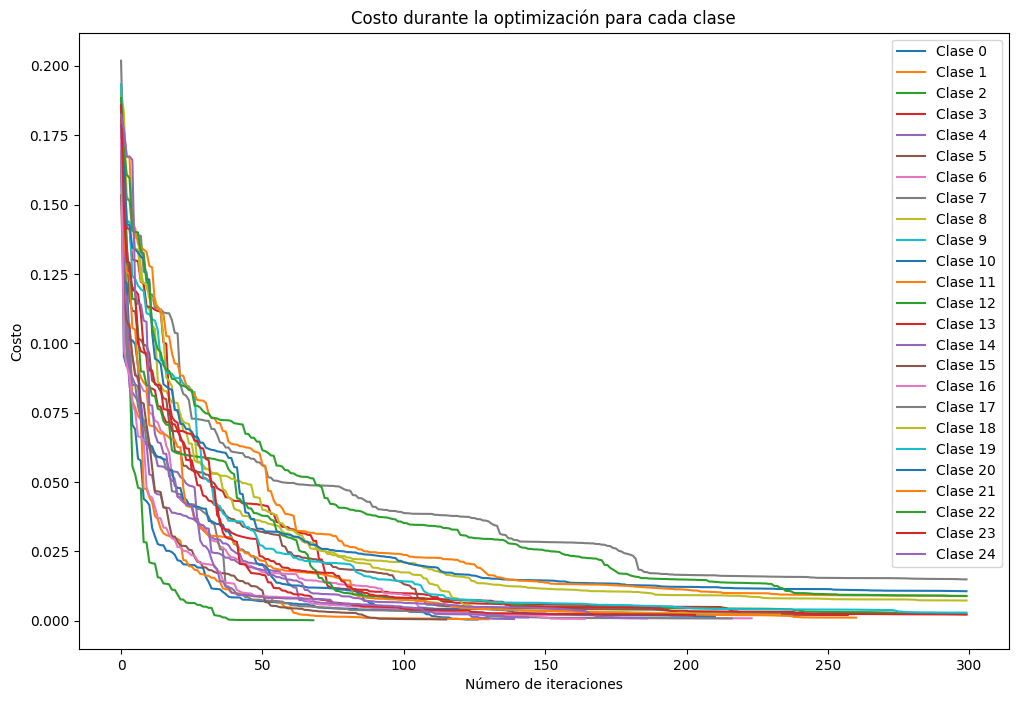

In [22]:
plot_cost(cost_histories)

#### 1.6.2 Predicciónn One-vs-all

Después de entrenar el clasificador de one-vs-all, se puede usarlo para predecir el dígito contenido en una imagen determinada. Para cada entrada, debe calcular la "probabilidad" de que pertenezca a cada clase utilizando los clasificadores de regresión logística entrenados.

In [23]:
def predictOneVsAll(all_theta, X):

    m = X.shape[0];
    num_labels = all_theta.shape[0]

    p = np.zeros(m)

    # Añade una columna de 1
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis = 1)

    return p

Precisión de entrenamiento y prueba

In [24]:
pred_train = predictOneVsAll(all_theta, X_train)
print('Precision del conjuto de entrenamiento: {:.2f}%'.format(np.mean(pred_train == y_train) * 100))

pred_test = predictOneVsAll(all_theta, X_test)
print('Precision del conjuto de entrenamiento: {:.2f}%'.format(np.mean(pred_test == y_test) * 100))

Precision del conjuto de entrenamiento: 99.93%
Precision del conjuto de entrenamiento: 98.67%


#### 1.6.3 Predicción con Softmax
+ **Softmax:** La función softmax(z) calcula las probabilidades normalizadas para cada clase basada en los puntajes lineales (z). Esto asegura que las probabilidades sumen 1 y se puede interpretar directamente como la probabilidad de pertenencia a cada clase.

+ **Predicción con Softmax:** La función predict_softmax(X, all_theta) utiliza los parámetros theta entrenados para cada clase y calcula los puntajes para cada clase, aplicando Softmax para determinar la probabilidad y seleccionando la clase con la mayor probabilidad.

In [25]:
def softmax(z):
    exp_z = np.exp(z - np.max(z))  # Restar max(z) para estabilidad numérica
    return exp_z / exp_z.sum(axis=1, keepdims=True)

def predict_softmax(X, all_theta):
    # Añade una columna de 1
    X = np.c_[np.ones(X.shape[0]), X]
    # Calcula los puntajes para todas las clases usando theta de cada modelo
    z = X.dot(all_theta.T)
    # Aplica softmax para obtener las probabilidades
    probs = softmax(z)
    # Predice la clase con la probabilidad más alta
    return np.argmax(probs, axis=1)

Calculamos las predicciones y la precisión de la prueba

In [26]:
y_pred = predict_softmax(X_train, all_theta)
print(f"Predicciones usando Softmax: {y_pred[:10]}")

# Calcular la precisión del entrenamiento
accuracy = np.mean(y_pred == y_train) * 100
print(f"Precisión del entrenamiento usando Softmax: {accuracy:.2f}%")

Predicciones usando Softmax: [ 3  6  2  2 13 16  8 22  3  3]
Precisión del entrenamiento usando Softmax: 99.93%
